<a href="https://colab.research.google.com/github/jasreman8/Multi-Agent-System-Projects/blob/main/Agentic_RAG_Router_and_Hallucination_GuardRails.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Objectives

*   Implement a RAG (Retrieval Augmented Generation) system that can dynamically choose between different knowledge sources (vector store vs. web search).
*   Implement a hallucination check to assess the groundedness of an agent's response against retrieved context. Build a graph-based workflow with an conditional agent based on the hallucination check outcome.

# Business Scenario

A financial services company wants to build an AI assistant for its analysts. This assistant needs to answer complex questions about publicly traded companies.

**Challenges:**
*   Some questions require deep dives into specific company financial disclosures (like Tesla's 10-K reports).
*   Other questions might be about recent news, general market trends, or competitors, requiring up-to-date web search capabilities.
*   The generated answers must be accurate and grounded in reliable sources, minimizing hallucinations.
*   The system should be able to self-correct if an initial answer is found to be poorly supported by evidence.

# Implementation Plan

This system works like a smart Q&A assistant with specialized helpers and a quality control step:

1.  **Understand the Question's Intent:** When a user asks a question, the system first tries to figure out the best way to answer it. Is it a question about specific, historical company data we have on file (like Tesla's financial reports from 2019-2023)? Or is it a more general question, perhaps about recent news or another company, that would require searching the internet? This decision is made by a "Router."

2.  **Assign to a Specialist:**
    *   If the Router decides the question is about our internal Tesla financial reports, it sends the question to a "RAG Specialist." This specialist is good at looking through these specific documents and finding relevant information to formulate an answer.
    *   If the Router decides the question needs broader knowledge, it sends it to a "Web Search Specialist." This specialist uses a search engine to find current information online and then formulates an answer.

3.  **Generate an Answer:** The chosen specialist (either RAG or Web Search) does its work and comes up with an answer.

4.  **Fact-Check the Answer:** Before giving the answer to the user, the system performs a "Hallucination Check." It looks at the information the specialist used (e.g., parts of the financial reports or web search results) and compares it to the answer. It asks: "Is this answer actually supported by the evidence the specialist found?"

5.  **Decide What's Next:**
    *   **If the answer passes the fact-check:** Great! The system considers this a good answer and provides it to the user. The process ends here for this question.
    *   **If the answer fails the fact-check (it seems like a hallucination):** The system tells the *same specialist* that its previous answer wasn't good enough and asks it to try again, emphasizing the need to stick to the facts it found. The specialist then goes back to step 3 (Generate an Answer), and the process continues with another fact-check (step 4).

This loop of generating an answer, fact-checking it, and retrying if necessary helps ensure the final answer is as accurate and reliable as possible. The whole process is managed as a "workflow" where each step hands off information to the next.



*Notes:*
 - LLM-based hallucination detection utilizes a language model to assess whether its outputs align with the provided context, identifying discrepancies that suggest hallucinations.
 - ChromaDB library is imported for vector database operations.
 - ChromaDB enables efficient storage, retrieval, and management of vector embeddings, facilitating semantic search and Retrieval-Augmented Generation (RAG) tasks.

# Setup

!pip install -q openai==1.66.3 \
                chromadb==0.6.3 \
                langchain==0.3.20 \
                langchain-openai==0.3.9 \
                langchain-community==0.3.19 \
                langchain-chroma==0.2.2 \
                langgraph==0.3.21

In [2]:
import os, chromadb, logging

from typing import Literal, List, Dict, TypedDict, Optional

from pydantic import BaseModel, Field

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage

from langchain.tools.retriever import create_retriever_tool

from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings, ChatOpenAI

from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import create_react_agent

from langchain_community.tools.tavily_search import TavilySearchResults

from google.colab import userdata

# Hide warnings/logs from Chroma
# This code mutes the following telemetry error in ChromaDB:
# ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
logging.getLogger("chromadb").setLevel(logging.CRITICAL)

In [3]:
openai_api_key = userdata.get('OPEN_API_KEY')

os.environ['TAVILY_API_KEY'] = userdata.get('tavily_search_api_key')

llm = ChatOpenAI(
    api_key=openai_api_key,
    base_url="https://aibe.mygreatlearning.com/openai/v1",
    model='gpt-4o-mini',
    temperature=0
)

embedding_model = OpenAIEmbeddings(
    api_key=openai_api_key,
    base_url="https://aibe.mygreatlearning.com/openai/v1",
    model="text-embedding-3-small"
)

In [4]:
! unzip tesla_db.zip

chromadb_client = chromadb.PersistentClient(
    path=r'./tesla_db'
)

chromadb_client.list_collections()

Archive:  tesla_db.zip
   creating: tesla_db/
  inflating: tesla_db/chroma.sqlite3  
   creating: tesla_db/e5401e39-e25e-4be0-8e53-57cb38e8c579/
  inflating: tesla_db/e5401e39-e25e-4be0-8e53-57cb38e8c579/header.bin  
  inflating: tesla_db/e5401e39-e25e-4be0-8e53-57cb38e8c579/link_lists.bin  
  inflating: tesla_db/e5401e39-e25e-4be0-8e53-57cb38e8c579/length.bin  
  inflating: tesla_db/e5401e39-e25e-4be0-8e53-57cb38e8c579/index_metadata.pickle  
  inflating: tesla_db/e5401e39-e25e-4be0-8e53-57cb38e8c579/data_level0.bin  


['tesla-10k-2019-to-2023']

In [6]:
tesla_10k_collection = 'tesla-10k-2019-to-2023'

vectorstore_persisted = Chroma(
    collection_name=tesla_10k_collection, # loads already-persisted embeddings from disk.
    collection_metadata={"hnsw:space": "cosine"}, # uses cosine similarity for nearest-neighbor search
    embedding_function=embedding_model, # associates store with embedding model to embed incoming queries
    client=chromadb_client, # associates store with chromadb_client point to the unzipped queries
    persist_directory=r'./tesla_db'
)

retriever = vectorstore_persisted.as_retriever(
    search_type='similarity',
    search_kwargs={'k': 5}
)# This step converts the vector store into a retriever.
# This retriever is a retrieval interface that:
# 1) takes a text query,
# 2) embeds it using embedding_model,
# 3) performs cosine similarity search,
# 4) returns the top 5 most similar chunks to the query in the embedding space from the Tesla 10-Ks.

# Tool Definitions

This section defines the "tools" that the agents can use. Tools are essentially functions or capabilities that an LLM agent can decide to call to get more information or perform actions.
1.  **Retriever Tool (`retriever_tool`):**
    *   `create_retriever_tool` is a Langchain utility that wraps the `retriever` (created in the previous step) into a formal `Tool`.
    *   It's given a name (`"retrieve_tesla_10k_documents"`) and a description. This name and description are crucial because the LLM agent will use them to understand what the tool does and when to use it.
2.  **Web Search Tool (`web_search_tool`):**
    *   An instance of `TavilySearchResults` is created. Tavily is a search API optimized for LLM applications.
    *   `k=3` specifies that the tool should return the top 3 search results.
3.  **Tool Lists:** The tools are organized into lists (`rag_tools` and `web_search_tools`) for easy assignment to their respective agents later.


In [7]:
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_tesla_10k_documents",
    """
    Search and return information mentioned in Tesla 10K documents from 2019 to 2023.
    """,
) # wrapping the retriever as an LLM-callable tool.
# This will enable the LLM to issue semantic searches over Tesla 10-K filings.

web_search_tool = TavilySearchResults(k=3) # This creates a live web search tool that returns the top 3 search results.

In [8]:
# Organizing the tools into logical categories for use in Agentic workflows.
rag_tools = [retriever_tool]
web_search_tools = [web_search_tool]

# Agent Definitions

In this section, two specialized agents are created using LangGraph's `create_react_agent` prebuilt. A ReAct (Reasoning and Acting) agent works by thinking about what to do, choosing a tool to act, observing the tool's output, and then repeating this cycle until it can answer the question.
1.  **RAG Agent (`rag_agent`):**
    *   This agent is given the main `llm` and the `retriever_tool`.
    *   Its purpose is to answer questions by first using the `retriever_tool` to fetch relevant information from Tesla's 10-K documents and then using the `llm` to synthesize an answer based on that information.
2.  **Web Search Agent (`web_search_agent`):**
    *   This agent is also given the `llm` but is equipped with the `web_search_tool`.
    *   Its purpose is to answer questions by using the `web_search_tool` to find information on the internet and then using the `llm` to generate an answer based on the search results.

Each agent is an independent runnable unit that can process a sequence of messages (like a question) and produce a response, potentially calling its assigned tools in the process.

In [9]:
# We are creating two differently tooled ReAct agents, each capable of reasoning + acting independently.
rag_agent = create_react_agent(
    llm,
    tools=[retriever_tool]
) # this agent can reason about the question, decide when to call the Tesla 10K retriever, act by retrieving internal documents, and use results to answer.

web_search_agent = create_react_agent(
    llm,
    [web_search_tool]
) # this agent can reason about the queries needing external or current info, call the web search tool, and synthesize answers from live results.

 - The RAG agent uses the retriever tool (vector store) to fetch answers. The Web Search Agent utilizes the web_search_tool to query real-time external information.

# Router Definition

This section defines the logic for the "Router" node in the graph. Its job is to decide which agent (RAG or Web Search) is best suited to handle the user's question.
1.  **`RouteQuery` Pydantic Model:**
    *   This class defines the expected output structure from the LLM when it acts as a router.
    *   It has one field, `datasource`, which must be either `"rag_agent"` or `"web_search_agent"`.
    *   The `Field` description guides the LLM on how to choose the correct datasource.
2.  **`structured_llm_router`:**
    *   The `llm.with_structured_output(RouteQuery)` method modifies the LLM to force its output to conform to the `RouteQuery` Pydantic model. This ensures the LLM's routing decision is returned in a predictable, usable format.
3.  **`router_system` Prompt:**
    *   This system message provides context and instructions to the LLM for its routing task. It clearly describes the capabilities of each agent (`rag_agent` and `web_search_agent`).
4.  **`route_prompt`:**
    *   A `ChatPromptTemplate` is created, combining the `router_system` message with a placeholder for the user's `question`.
5.  **`question_router` Chain:**
    *   This chain combines the `route_prompt` with the `structured_llm_router`. When this chain is invoked with a question, it will:
        *   Format the prompt.
        *   Send it to the LLM.
        *   The LLM will make a decision and output it in the `RouteQuery` format.

In [10]:
class RouteQuery(BaseModel):
    """Route a user query to the most relevant agent."""
    datasource: Literal["rag_agent", "web_search_agent"] = Field(
        description="Given a user question, choose to route it to 'rag_agent' if it specifically asks about Tesla's 10K reports (2019-2023) or 'web_search_agent' for general knowledge, recent events, or other companies.",
)
# This class defines a strict contract for routing decisions. The LLM must output exactly one of rag_agent/web_search_agent.

structured_llm_router = llm.with_structured_output(RouteQuery) # wrapping the LLM so that the output is validated against RouteQuery.
# structured_llm_router decides how the model must answer (schema/JSON-like).

router_system = """You are an expert at routing a user question to the appropriate agent.
- The 'rag_agent' has access to Tesla's 10-K financial reports from 2019 to 2023. Use it for specific questions about Tesla's finances, operations, risks, etc., mentioned in those documents.
- The 'web_search_agent' can search the web for general knowledge, recent information, or information about companies other than Tesla based on its 10k reports.

Based on the user question, decide which agent is most suitable."""

route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", router_system),
        ("human", "{question}"),
    ]
) # building a router prompt that injects routing roles, and takes a user question dynamically. It decides what to stay to the model.

question_router = route_prompt | structured_llm_router # this creates a callable routing chain.

# This block turns an LLM into a deterministic router that classifies a user question and routes it to the correct agent using structured output instead of free-text reasoning.

# Hallucination Grader

This section defines the "Hallucination Grader." Its purpose is to evaluate if an agent's generated answer is factually supported by the documents or information the agent retrieved (the "context").
1.  **`GradeHallucinations` Pydantic Model:**
    *   Defines the expected output structure for the grader LLM.
    *   It has one field, `binary_score`, which should be either `"yes"` (answer is supported) or `"no"` (answer is not supported/hallucinated).
2.  **`structured_llm_grader`:**
    *   Similar to the router, `llm.with_structured_output(GradeHallucinations)` ensures the LLM's grading output conforms to the `GradeHallucinations` model.
3.  **`system_grader` Prompt:**
    *   The system message for the grader LLM, instructing it on its task: assess if the `GENERATION` is supported by the `CONTEXT`.
4.  **`hallucination_prompt`:**
    *   A `ChatPromptTemplate` that will provide the grader LLM with the retrieved `documents` (context) and the agent's `generation` (answer) for assessment.
5.  **`hallucination_grader` Chain:**
    *   Combines the `hallucination_prompt` and `structured_llm_grader`. When invoked, it will ask the LLM to grade the generation based on the context and return a "yes" or "no".
6.  **`extract_context_from_messages` Function:**
    *   This utility function is designed to extract the content from `ToolMessage` objects within a list of agent messages. When an agent uses a tool (like the retriever or web search), the tool's output is typically packaged as a `ToolMessage`. This function gathers these outputs to form the "context" against which the agent's final answer will be checked for hallucinations.

In [11]:
# Defining the grading output schema
class GradeHallucinations(BaseModel):
    """Binary score for hallucination check."""
    binary_score: str = Field(description="Is the generation supported by the provided context? 'yes' or 'no'") # Defines a strict output contract.

# Convert the LLM into a structured grader
structured_llm_grader = llm.with_structured_output(GradeHallucinations) # forces the LLM to behave like a classifier/judge

# Defining the grading instructions (policy)
system_grader = """You are a grader assessing whether an LLM generation is grounded in/supported by a set of context facts.
Provide a binary score 'yes' or 'no'. 'Yes' means the answer IS supported by the context."""

# Build the hallucination-check prompt
hallucination_prompt = ChatPromptTemplate.from_messages([
    ("system", system_grader),
    ("human", "CONTEXT:\n\n{documents}\n\nGENERATION:\n{generation}")
])

hallucination_grader = hallucination_prompt | structured_llm_grader

# This code turns an LLM into a strict yes/no judge that checks whether an answer is grounded in retrieved context, using structured output to prevent vague grading.

In [12]:
# Extract context from tool messages
def extract_context_from_messages(messages: List[BaseMessage]) -> str:
    """Extracts content from ToolMessages to use as context."""
    tool_outputs = [msg.content for msg in messages if isinstance(msg, ToolMessage)]
    # You might want to format this better depending on tool output structure
    return "\n\n".join(tool_outputs)

# Workflow State Definition

This `TypedDict` defines the structure of the state that will be passed around and updated by the different nodes in the LangGraph workflow. A `TypedDict` is a way to define a dictionary where keys have specific types.
Each field in `WorkflowState` represents a piece of information that is relevant to the workflow's execution:
*   `question`: The initial user question.
*   `agent_choice`: The agent chosen by the router node (e.g., "rag\_agent" or "web\_search\_agent").
*   `final_answer`: The answer generated by the chosen agent.
*   `agent_messages`: The history of messages exchanged with the agent, including tool calls and responses. This is useful for providing context for retries and for extracting tool outputs for the hallucination check.
*   `context_for_hallucination_check`: The actual context (e.g., retrieved document snippets) used for the hallucination check.
*   `hallucination_check_result`: The result of the hallucination check ("yes" or "no").

As the workflow progresses, different nodes will read from and write to this state object.


In [14]:
class WorkflowState(TypedDict):
    question: str
    agent_choice: Optional[str]
    final_answer: Optional[str]
    agent_messages: Optional[List[BaseMessage]]
    # Added fields for hallucination check
    context_for_hallucination_check: Optional[str]
    hallucination_check_result: Optional[str] # Stores 'yes' or 'no'

# We are defining a shared, typed state object that flows through our entire LangGraph workflow.
# CRITICAL --> This will allow different nodes (routers, agents, graders) to read from and write to the same structured memory.

# Node Functions

These functions define the actions performed by each node in the graph. Each node function takes the current `WorkflowState` as input and returns a dictionary representing the updates to the state.


 - The node function takes the current workflow state and performs specific operations, such as routing, retrieval, and hallucination checks.

In [15]:
# --- Node Functions ---
def route_question(state: WorkflowState) -> Dict:
    """Routes the question to the appropriate agent."""
    print("--- ROUTING QUESTION ---")
    question = state['question']
    routing_result = question_router.invoke({"question": question})
    print(f"Routing decision: {routing_result.datasource}")
    return {"agent_choice": routing_result.datasource, "question": question} # Pass question explicitly if needed downstream

# This functions decides which agent should handle the user query.

This node is responsible for routing the user's question. It takes the `question` from the current state, invokes the `question_router` (defined in Section 6) to get a routing decision, and then updates the state with this `agent_choice`.
*   **Syntax:**
    *   `state: WorkflowState`: Type hint indicating the input is the workflow's state.
    *   `-> Dict`: Type hint indicating the function returns a dictionary (which will update the state).
    *   `question = state['question']`: Accesses the 'question' field from the input state.
    *   `routing_result = question_router.invoke({"question": question})`: Calls the router chain with the question.
    *   `return {"agent_choice": routing_result.datasource, "question": question}`: Returns a dictionary. LangGraph will merge this dictionary into the current workflow state. `routing_result.datasource` will be "rag\_agent" or "web\_search\_agent".


In [16]:
# --- Agent Call Nodes ---
def call_rag_agent(state: WorkflowState) -> Dict:
    """Invokes the RAG agent, potentially with retry feedback."""
    print("--- CALLING RAG AGENT ---")
    question = state['question']
    agent_messages = state.get("agent_messages", []) # Get previous messages if retrying
    is_retry = state.get("hallucination_check_result") == "no"

    input_messages = []
    if is_retry and agent_messages:
        print("--- RETRYING RAG AGENT (Hallucination Detected) ---")
        # Pass original question and feedback
        # Using the full previous history might confuse the agent, let's try focused feedback
        feedback = (
            f"Your previous answer was not fully supported by the retrieved documents. "
            f"Please answer the original question: '{question}' strictly using the information "
            f"provided by the 'retrieve_tesla_10k_documents' tool."
        )
        input_messages.append(HumanMessage(content=feedback))
    else:
         # First attempt
        input_messages.append(HumanMessage(content=question))

    agent_input = {"messages": input_messages}
    response_state = rag_agent.invoke(agent_input)

    final_message = response_state['messages'][-1] if response_state['messages'] else None
    final_answer = final_message.content if isinstance(final_message, AIMessage) else "Agent error: No final answer."

    # Return the full message history for the next step (hallucination check)
    return {"final_answer": final_answer, "agent_messages": response_state['messages']}

def call_web_search_agent(state: WorkflowState) -> Dict:
    """Invokes the Web Search agent, potentially with retry feedback."""
    print("--- CALLING WEB SEARCH AGENT ---")
    question = state['question']
    agent_messages = state.get("agent_messages", [])
    is_retry = state.get("hallucination_check_result") == "no"

    input_messages = []
    if is_retry and agent_messages:
        print("--- RETRYING WEB SEARCH AGENT (Hallucination Detected) ---")
        feedback = (
            f"Your previous answer was not fully supported by the search results. "
            f"Please answer the original question: '{question}' strictly using the information "
            f"provided by the 'web_search' tool."
        )
        input_messages.append(HumanMessage(content=feedback))
    else:
        input_messages.append(HumanMessage(content=question))

    agent_input = {"messages": input_messages}
    response_state = web_search_agent.invoke(agent_input)

    final_message = response_state['messages'][-1] if response_state['messages'] else None
    final_answer = final_message.content if isinstance(final_message, AIMessage) else "Agent error: No final answer."

    print(f"Web Search Agent Raw Output: {final_answer[:150]}...")
    return {"final_answer": final_answer, "agent_messages": response_state['messages']}

The above nodes invoke their respective agents (`rag_agent` or `web_search_agent`). They include logic for retries.

- They check if this is a retry attempt (i.e., if `hallucination_check_result` in the state was "no").
- If it's a retry, a `HumanMessage` containing feedback and the original question is constructed. This feedback guides the agent to be more careful and stick to the provided documents/tool output.
- If it's the first attempt, the input is just the original `question`.
- The appropriate agent is invoked with the prepared input messages.
- The agent's final answer and the full list of messages (including tool calls/outputs) from the agent's execution are extracted and returned to update the workflow state. The `agent_messages` are crucial for the subsequent hallucination check.

In [17]:
# --- Node for Hallucination Check ---
def check_hallucinations(state: WorkflowState) -> Dict:
    """Checks the generated answer against the context from agent messages."""
    print("--- CHECKING HALLUCINATIONS ---")
    final_answer = state.get("final_answer", "")
    agent_messages = state.get("agent_messages", [])

    if not final_answer or final_answer.startswith("Agent error:"):
        print("--- Hallucination Check Skipped (No valid answer) ---")
        # Treat as hallucinated to potentially trigger retry or indicate failure
        return {"hallucination_check_result": "no"}

    context = extract_context_from_messages(agent_messages)

    if not context:
        print("--- Hallucination Check Skipped (No context found) ---")
        # If no tools were called, we can't check grounding. Assume OK for now.
        # Or, force a 'no' if context is expected. Let's assume OK if context is missing.
        return {"hallucination_check_result": "yes", "context_for_hallucination_check": ""}

    grade = hallucination_grader.invoke({"documents": context, "generation": final_answer})
    result = grade.binary_score
    print(f"Hallucination Check Result: {result}")
    return {"hallucination_check_result": result, "context_for_hallucination_check": context}

This node performs the hallucination check.
- It retrieves the `final_answer` and `agent_messages` from the state.
- It handles edge cases: if there's no valid `final_answer` (e.g., an agent error occurred), it defaults the check result to "no" (treat as hallucinated to potentially trigger a retry or signal failure).
- It calls `extract_context_from_messages` (defined in Section 7) to get the tool outputs (documents, search results) that the agent used.
- If no context is found (e.g., the agent didn't use any tools, or the tools returned nothing), it skips the actual grading. The current logic returns "yes", implying it's not a hallucination if no context was explicitly used for grounding (this could be refined; for a RAG agent, lack of context is usually bad).
- If context is available, it invokes the `hallucination_grader` (defined in Section 7) with the `context` and the `final_answer`.
- The grader's `binary_score` ("yes" or "no") is returned to update the state, along with the context itself.

In [18]:
# --- Decision Function for Looping ---
def decide_after_hallucination_check(state: WorkflowState) -> str:
    """Decides whether to end or loop back to the agent based on hallucination check."""
    print("--- DECIDING NEXT STEP ---")
    hallucination_result = state.get("hallucination_check_result")
    agent_choice = state.get("agent_choice") # The agent that just ran

    if hallucination_result == "yes":
        print("--- DECISION: Hallucination check passed. END ---")
        return "end" # Go to END
    else:
        print(f"--- DECISION: Hallucination detected. Retry '{agent_choice}' ---")
        # The keys in the conditional edge map must match this return value
        return agent_choice # Return the name of the agent node to retry

The above function is used by a conditional edge in the graph. After the `check_hallucinations` node runs, this function determines the next step.
- It reads the `hallucination_check_result` and the `agent_choice` (which agent just ran) from the state.
- If the hallucination check passed (`"yes"`), it returns the string `"end"`. This will direct the workflow to the special `END` node, terminating the process for this query.
- If the hallucination check failed (`"no"`), it returns the `agent_choice` string (e.g., `"rag_agent"` or `"web_search_agent"`). This string will be used by the conditional edge to route the workflow back to the *same agent* that just ran, effectively creating a retry loop.


# Graph Construction

In this section, the workflow graph is assembled using LangGraph.
1.  **Initialize Graph:** `workflow = StateGraph(WorkflowState)` creates a new stateful graph. `WorkflowState` (defined in Section 8) tells LangGraph the structure of the data that will be passed between nodes.
2.  **Add Nodes:**
    *   `workflow.add_node("node_name", function_name)` adds each processing step (defined in Section 9) as a node in the graph. The first argument is a unique string name for the node, and the second is the callable (function) that executes the node's logic.
    *   The node names (`"rag_agent"`, `"web_search_agent"`) are deliberately chosen to match the possible output values of the `RouteQuery.datasource` and the return values of `decide_after_hallucination_check` for routing.
3.  **Define Edges:** Edges connect the nodes and define the flow of control.
    *   **Conditional Edges from Router:** `workflow.add_conditional_edges("router", lambda state: state["agent_choice"], {...})`
        *   This connects the "router" node to either "rag\_agent" or "web\_search\_agent".
        *   The second argument is a function that takes the current state and returns a key. Here, `lambda state: state["agent_choice"]` directly uses the `agent_choice` field set by the router node.
        *   The third argument is a dictionary mapping these keys to the names of the next nodes. So, if `agent_choice` is "rag\_agent", it goes to the "rag\_agent" node.
    *   **Direct Edges to Hallucination Check:** `workflow.add_edge("rag_agent", "hallucination_check")` and `workflow.add_edge("web_search_agent", "hallucination_check")`
        *   These create direct connections. After either the "rag\_agent" or "web\_search\_agent" node finishes, the workflow will always proceed to the "hallucination\_check" node.
    *   **Conditional Edges from Hallucination Check:** `workflow.add_conditional_edges("hallucination_check", decide_after_hallucination_check, {...})`
        *   This connects the "hallucination\_check" node to either an agent node (for a retry) or the `END` state.
        *   The `decide_after_hallucination_check` function (from Section 10) determines the key ("rag\_agent", "web\_search\_agent", or "end").
        *   The dictionary maps these keys to the next node. `END` is a special LangGraph object representing the termination of the workflow.
4.  **Compile Workflow:** `compiled_workflow = workflow.compile()` finalizes the graph structure and returns a runnable `CompiledGraph` object.

In [19]:
# --- Build the Graph ---
workflow = StateGraph(WorkflowState)

# Add nodes
workflow.add_node("router", route_question)
# Node names match the Literal in RouteQuery and the return values of decide_after_hallucination_check
workflow.add_node("rag_agent", call_rag_agent)
workflow.add_node("web_search_agent", call_web_search_agent)
workflow.add_node("hallucination_check", check_hallucinations)

# Define edges
workflow.add_edge(START, "router")

# Routing from router to agent
workflow.add_conditional_edges(
    "router",
    lambda state: state["agent_choice"],
    {
        "rag_agent": "rag_agent",
        "web_search_agent": "web_search_agent",
    }
)

# Edges from agents to hallucination check
workflow.add_edge("rag_agent", "hallucination_check")
workflow.add_edge("web_search_agent", "hallucination_check")

# Conditional edge from hallucination check
workflow.add_conditional_edges(
    "hallucination_check",
    decide_after_hallucination_check, # Function to decide the next step
    {
        "rag_agent": "rag_agent",          # If decision returns "rag_agent", go to rag_agent node
        "web_search_agent": "web_search_agent", # If decision returns "web_search_agent", go to web_search_agent node
        "end": END                        # If decision returns "end", go to END
    }
)
# The function's return value is used as a key to select the next node or END.

# Compile the workflow
compiled_workflow = workflow.compile()

In [20]:
graph = compiled_workflow.get_graph().draw_mermaid_png(output_file_path='adaptive-rag.png')

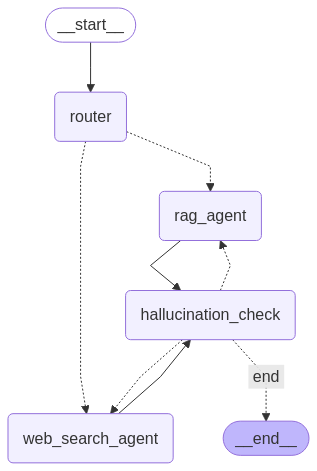

# Workflow Exection

This section demonstrates how to run the compiled workflow with different example queries.
1.  **Define Query:** A sample question is stored in the `query` variable.
2.  **Prepare Input:** The input for the workflow is a dictionary. Since the `WorkflowState` (and the entry node "router") expects a `question` field, the input is `{'question': query}`.
3.  **Invoke Workflow:** `compiled_workflow.invoke(inputs)` executes the entire graph starting from the entry point with the provided inputs. LangGraph manages the state transitions and node executions based on the defined graph structure. The `invoke` method will run until the graph reaches an `END` state.


Three different queries are shown:
*   The first query ("What is the current stock price of Ford?") should be routed to the `web_search_agent` because it's about a different company and requires current information.
*   The second query ("What were Tesla's total revenues in 2022 according to their 10k?") should be routed to the `rag_agent` as it specifically asks for information from Tesla's 10-K reports.
*   The third query ("What specific features were announced for the Tesla Cybertruck in Q1 2024 according to the 10k reports?") is designed to potentially test the RAG agent's limits or the hallucination check. Since 10-K reports are annual and backward-looking, detailed Q1 2024 product announcements might not be in the 2019-2023 10-K data. The RAG agent might not find relevant info, or the hallucination check might play a role if it tries to synthesize an answer without strong evidence from the documents.


 - QUERY 1

In [21]:
query = "What is the current stock price of Ford?"

inputs = {
    'question': query
}

response = compiled_workflow.invoke(inputs)

--- ROUTING QUESTION ---
Routing decision: web_search_agent
--- CALLING WEB SEARCH AGENT ---
Web Search Agent Raw Output: The current stock price of Ford Motor Company (NYSE: F) is $13.48. You can find more details about the stock [here](https://robinhood.com/stocks/F)....
--- CHECKING HALLUCINATIONS ---
Hallucination Check Result: yes
--- DECIDING NEXT STEP ---
--- DECISION: Hallucination check passed. END ---


In [22]:
print(response['final_answer'])

The current stock price of Ford Motor Company (NYSE: F) is $13.48. You can find more details about the stock [here](https://robinhood.com/stocks/F).


 - QUERY 2

In [23]:
query = "What were Tesla's total revenues in 2022 according to their 10k?"

inputs = {
    'question': query
}

response = compiled_workflow.invoke(inputs)

--- ROUTING QUESTION ---
Routing decision: rag_agent
--- CALLING RAG AGENT ---
--- CHECKING HALLUCINATIONS ---
Hallucination Check Result: yes
--- DECIDING NEXT STEP ---
--- DECISION: Hallucination check passed. END ---


In [24]:
print(response['final_answer'])

Tesla's total revenues for the year ended December 31, 2022, were $81,462 million.


 - QUERY 3

In [25]:
query = "What specific features were announced for the Tesla Cybertruck in Q1 2024 according to the 10k reports?"

inputs = {
    'question': query
}

response = compiled_workflow.invoke(inputs)

--- ROUTING QUESTION ---
Routing decision: rag_agent
--- CALLING RAG AGENT ---
--- CHECKING HALLUCINATIONS ---
Hallucination Check Result: no
--- DECIDING NEXT STEP ---
--- DECISION: Hallucination detected. Retry 'rag_agent' ---
--- CALLING RAG AGENT ---
--- RETRYING RAG AGENT (Hallucination Detected) ---
--- CHECKING HALLUCINATIONS ---
Hallucination Check Result: yes
--- DECIDING NEXT STEP ---
--- DECISION: Hallucination check passed. END ---


In [26]:
print(response['final_answer'])

The retrieved documents do not provide specific details about the features announced for the Tesla Cybertruck in Q1 2024. They mention that the Cybertruck is in development and that Tesla is focused on ramping up production capacity, but no specific features or announcements for Q1 2024 are detailed in the 10-K reports.


 - QUERY 4

In [27]:
query = "How did the Tesla stock grow from 2015 to 2025?"

inputs = {
    'question': query
}

response = compiled_workflow.invoke(inputs)

--- ROUTING QUESTION ---
Routing decision: web_search_agent
--- CALLING WEB SEARCH AGENT ---
Web Search Agent Raw Output: Tesla's stock (TSLA) has experienced significant growth from 2015 to 2025. Here's a summary of its performance over the years:

- **2015**: The averag...
--- CHECKING HALLUCINATIONS ---
Hallucination Check Result: yes
--- DECIDING NEXT STEP ---
--- DECISION: Hallucination check passed. END ---


In [28]:
print(response['final_answer'])

Tesla's stock (TSLA) has experienced significant growth from 2015 to 2025. Here's a summary of its performance over the years:

- **2015**: The average stock price was approximately **$15.34**, with a closing price of **$16.00** at the end of the year. The annual percentage change was **7.91%**.
  
- **2016**: The stock price saw a decline, averaging **$13.98**, with a closing price of **$14.25**. The annual change was **-10.97%**.

- **2017**: A recovery occurred, with an average price of **$20.95** and a closing price of **$20.76**, marking a **45.70%** increase.

- **2018**: The stock continued to grow, averaging **$21.15** and closing at **$22.19**, a **6.89%** increase.

- **2019**: The stock price surged, averaging **$18.24** and closing at **$25.70**, a **25.70%** increase.

- **2020**: This year marked a significant leap, with an average price of **$96.67** and a closing price of **$235.22**, resulting in a staggering **743.44%** increase.

- **2021**: The stock continued its u

 - QUERY 5

In [29]:
query = "How did the Eli Lily stock grow from 2015 to 2025?"

inputs = {
    'question': query
}

response = compiled_workflow.invoke(inputs)

--- ROUTING QUESTION ---
Routing decision: web_search_agent
--- CALLING WEB SEARCH AGENT ---
Web Search Agent Raw Output: Eli Lilly's stock (LLY) has experienced significant growth from 2015 to 2025. Here are some key points regarding its performance over this period:

1....
--- CHECKING HALLUCINATIONS ---
Hallucination Check Result: yes
--- DECIDING NEXT STEP ---
--- DECISION: Hallucination check passed. END ---


In [30]:
print(response['final_answer'])

Eli Lilly's stock (LLY) has experienced significant growth from 2015 to 2025. Here are some key points regarding its performance over this period:

1. **Stock Price Growth**: 
   - In 2015, Eli Lilly's stock was trading at approximately $80. By late 2025, the stock price had surged to around $1,046.12, reflecting a substantial increase over the decade.
   - This represents an increase of over 1,200%, showcasing the company's strong performance in the stock market.

2. **Key Milestones**:
   - The company has launched several successful drugs and treatments, contributing to its revenue growth and stock price appreciation.
   - Eli Lilly's focus on innovative therapies, particularly in diabetes and oncology, has driven investor confidence and market performance.

3. **Market Trends**:
   - The pharmaceutical sector has seen increased demand, and Eli Lilly has capitalized on this trend with its product offerings.
   - The company's strategic initiatives, including cost-cutting measures an